# PROJECT B - RUC0066


In [65]:
import numpy as np
import pandas as pd
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import recall_score, classification_report, confusion_matrix, make_scorer
from sklearn.neighbors import KNeighborsClassifier


# Creation of dataframe from CSV

In [37]:
with open('kddcup.names.txt', 'r') as file:
    lines = file.readlines()
    feature_names = [line.split(':')[0] for line in lines if ':' in line]

feature_names.append('class')

df = pd.read_csv('kddcup.data_10_percent.csv', header=None)
df.columns = feature_names

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494021 non-null  int64  
 1   protocol_type                494021 non-null  object 
 2   service                      494021 non-null  object 
 3   flag                         494021 non-null  object 
 4   src_bytes                    494021 non-null  int64  
 5   dst_bytes                    494021 non-null  int64  
 6   land                         494021 non-null  int64  
 7   wrong_fragment               494021 non-null  int64  
 8   urgent                       494021 non-null  int64  
 9   hot                          494021 non-null  int64  
 10  num_failed_logins            494021 non-null  int64  
 11  logged_in                    494021 non-null  int64  
 12  num_compromised              494021 non-null  int64  
 13 

## Dataset structure description
- Based on this output we can tell how many rows and columns this dataset contains
- We can also see count of non-null values for each data group as well as theirs datatype
- This dataset has 42 columns overall with each of them having 494020 records
- There are:
  - 15x float64 types
  - 23x int64 types
  - 4x object types


# Preprocessing

## Removal of duplicite values
Duplicates can skew the data distribution and lead to overfitting. Removing them ensures each record is unique.

In [38]:
dataset = df.drop_duplicates()

# Initial exploration

In [39]:
display(df.head())

print("Missing values:\n", df.isnull().sum())

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


Missing values:
 duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate             

## Drop of unnecesaary column
- We can drop some columns cause they are having a constant value
- I decided to drop num_outbound_cmds as example


In [41]:
if 'num_outbound_cmds' in df.columns:
    if df['num_outbound_cmds'].nunique() <= 1:
        df.drop(columns=['num_outbound_cmds'], inplace=True)

Now lets separate features by its type

In [42]:
cat_features = ['protocol_type', 'service', 'flag']

all_features = list(df.columns)
all_features.remove('class')
num_features = [col for col in all_features if col not in cat_features]

print("Categorical features:", cat_features)
print("Numeric features:", num_features)

Categorical features: ['protocol_type', 'service', 'flag']
Numeric features: ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


Now lets replace each categorical value with an integer (0, 1, 2, ...)

In [44]:
ord_enc = OrdinalEncoder()
df[cat_features] = ord_enc.fit_transform(df[cat_features])

display(df.head())

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,1.0,22.0,9.0,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,1.0,22.0,9.0,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,1.0,22.0,9.0,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,1.0,22.0,9.0,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,1.0,22.0,9.0,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


Many of the numeric features have large or varied scales. Thats why I am gonna use MinMaxScaler to bring all numeric features into [0, 1]

In [22]:
scaler = MinMaxScaler()
df[num_features] = scaler.fit_transform(df[num_features])

display(df[num_features].describe())

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,0.000823,4.363595e-06,0.000168,0.000045,0.002144,0.000005,0.001151,0.000030,0.148247,0.000012,...,0.911650,0.739865,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,0.012134,1.425228e-03,0.006409,0.006673,0.044935,0.001837,0.026070,0.003104,0.355345,0.002034,...,0.253903,0.415845,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.489989e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.180392,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,7.499542e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.488371e-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Data after preprocessing
## What I did?
- Dropped constant column
- Encoded categorical features (One-Hot Encoding)
- Performed minmax scale

In [23]:
print("Sample of the final preprocessed data:")
display(df.head())

Sample of the final preprocessed data:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,1.0,22.0,9.0,2.610418e-07,0.001057,0.0,0.0,0.0,0.0,...,0.035294,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0.0,1.0,22.0,9.0,3.446905e-07,0.000094,0.0,0.0,0.0,0.0,...,0.074510,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0.0,1.0,22.0,9.0,3.389216e-07,0.000259,0.0,0.0,0.0,0.0,...,0.113725,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0.0,1.0,22.0,9.0,3.158461e-07,0.000259,0.0,0.0,0.0,0.0,...,0.152941,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0.0,1.0,22.0,9.0,3.129617e-07,0.000394,0.0,0.0,0.0,0.0,...,0.192157,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


## Visualization of the dataset after preprocessing

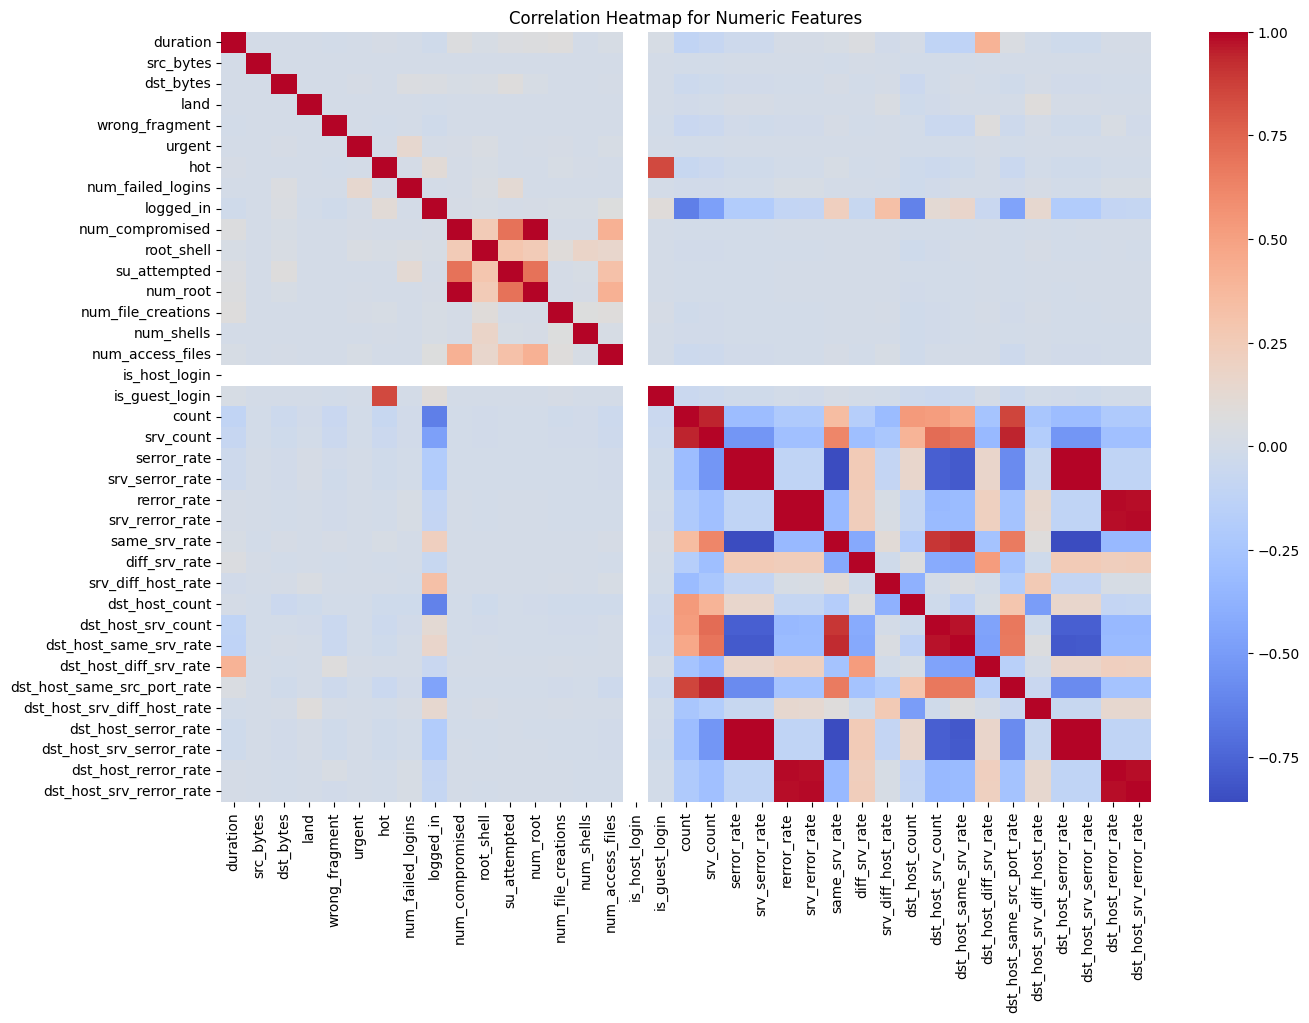

In [35]:
corr_matrix = df[num_features].corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap for Numeric Features")
plt.show()

<ipython-input-30-92e339b97c78>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['class'], order=df['class'].value_counts().index, palette="viridis")


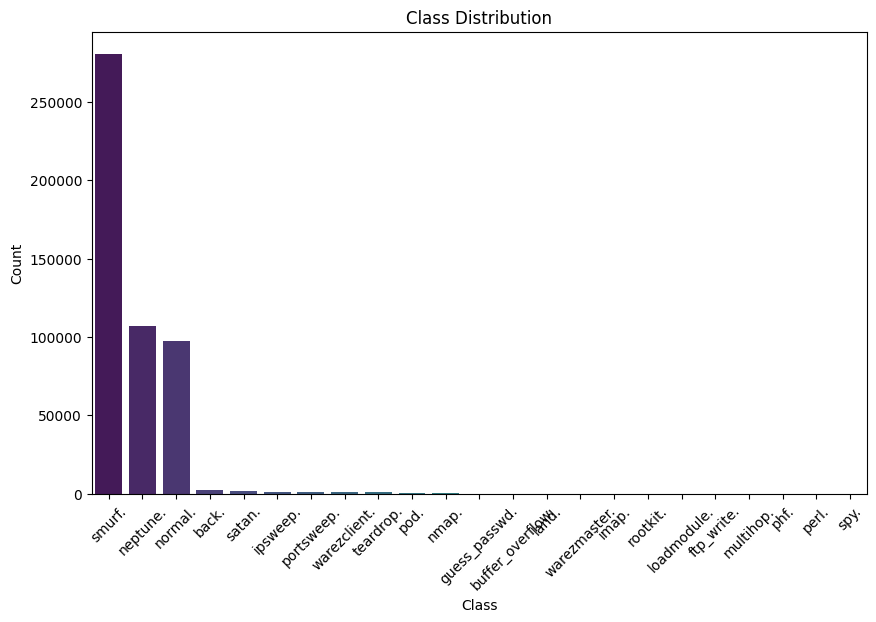

In [30]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df['class'], order=df['class'].value_counts().index, palette="viridis")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


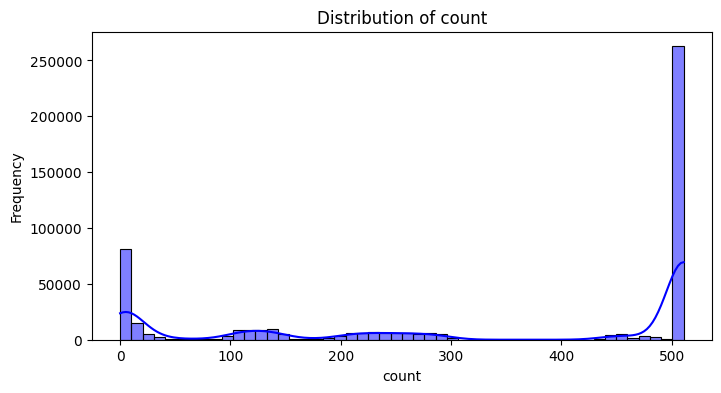

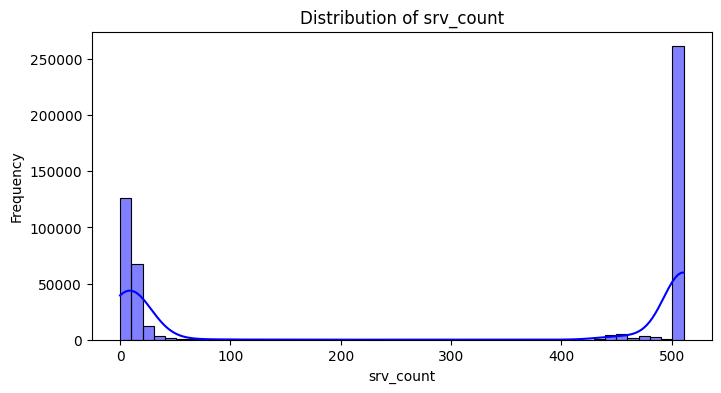

In [63]:
selected_features = ['count', 'srv_count']

for feature in selected_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[feature], kde=True, bins=50, color="blue")
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()


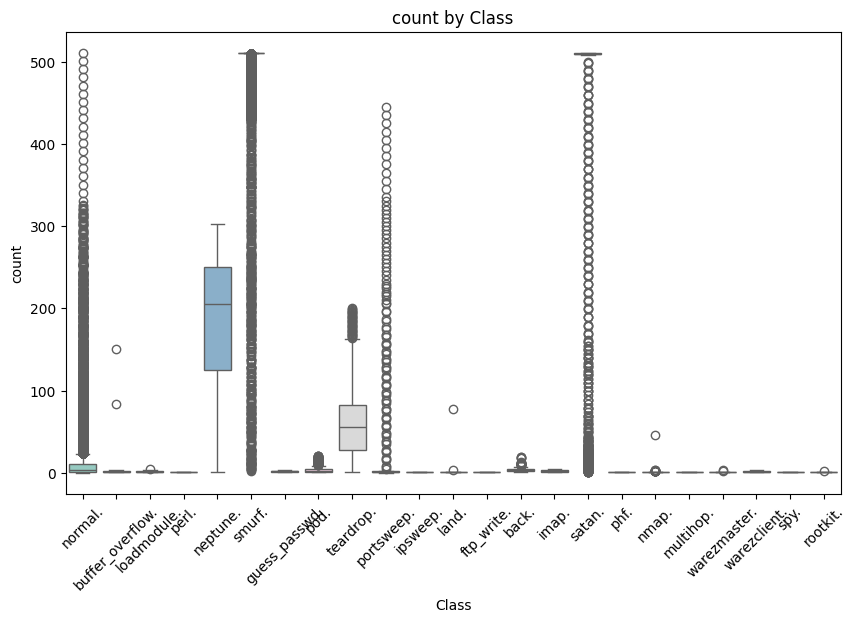

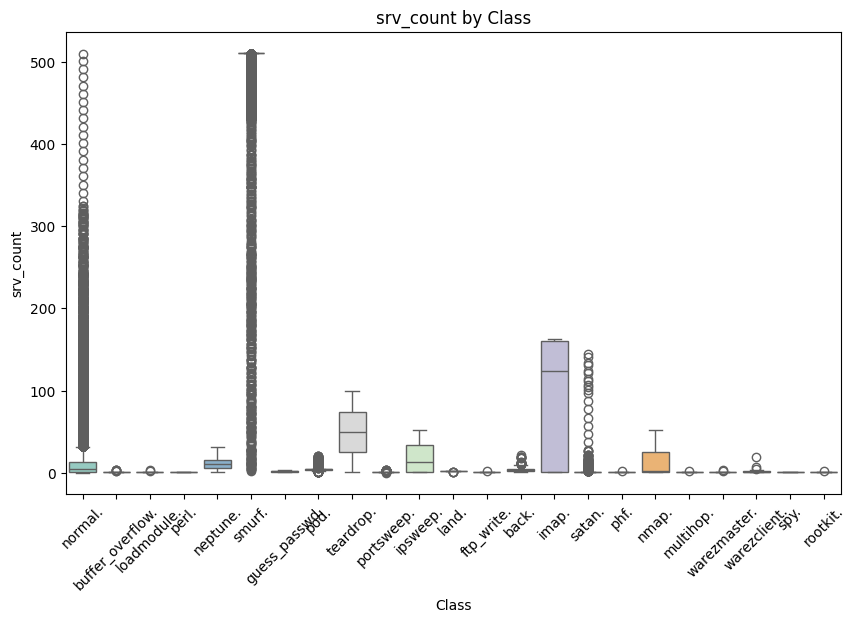

In [64]:
for feature in selected_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='class', y=feature, data=df, hue='class', palette="Set3")
    plt.title(f"{feature} by Class")
    plt.xlabel("Class")
    plt.ylabel(feature)
    plt.xticks(rotation=45)
    plt.show()


# Model performance metric

## Recall with Random Forest Classifier

In [53]:
X = df.drop('class', axis=1)
y = df['class']

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

rf_classifier = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall Score: {recall:.4f}")

Recall Score: 0.9998


## Output analysis
- Recall Score of 0.9998: This high recall indicates that the model successfully identifies 99.98% of the actual attack instances, minimizing false negatives (attacks that go undetected).

- by choosing and performing Recall metric, I have ve ensured that the model is highly effective in detecting attacks, which is crucial for intrusion detection systems where missing an attack can have severe consequences

# Classification algorithms

In [55]:
X = df.drop('class', axis=1)
y = df['class']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

## Decision Tree Classifier

- **Model:** Trained a Decision Tree Classifier with `class_weight='balanced'` to handle class imbalance.
- **Performance:**
  - Achieved a **weighted recall score of 0.9996**, detecting almost all instances correctly.
  - Dominant classes like "normal" and "smurf" had near-perfect precision, recall, and F1-scores.
  - Struggled with minority classes like "buffer_overflow" and "multihop," resulting in lower scores.
- **Confusion Matrix:** Showed excellent performance for major classes but revealed misclassifications for rare ones.
- **Improvements:** Could benefit from oversampling smaller classes or using ensemble methods to enhance robustness.


[Decision Tree] Recall Score: 0.9996

[Decision Tree] Classification Report:
                  precision    recall  f1-score   support

           back.       1.00      1.00      1.00       441
buffer_overflow.       0.50      0.50      0.50         6
      ftp_write.       0.00      0.00      0.00         2
   guess_passwd.       1.00      0.91      0.95        11
           imap.       1.00      0.50      0.67         2
        ipsweep.       1.00      0.98      0.99       249
           land.       1.00      1.00      1.00         4
     loadmodule.       0.00      0.00      0.00         2
       multihop.       0.00      0.00      0.00         1
        neptune.       1.00      1.00      1.00     21440
           nmap.       0.98      0.98      0.98        46
         normal.       1.00      1.00      1.00     19456
           perl.       1.00      1.00      1.00         1
            phf.       0.00      0.00      0.00         1
            pod.       1.00      1.00      1.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


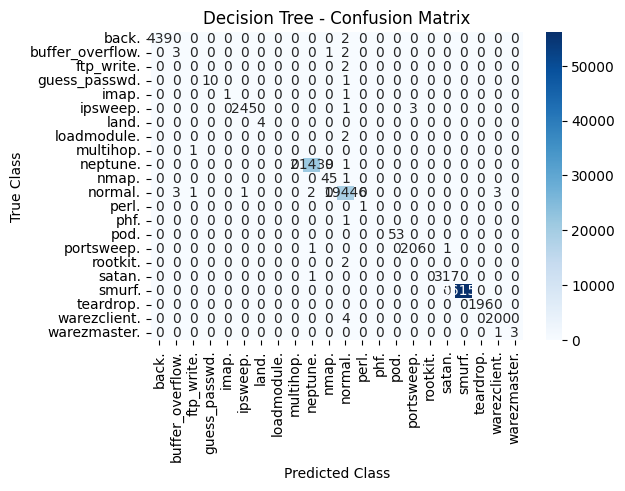

In [67]:
dt_classifier = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced'
)

dt_classifier.fit(X_train, y_train)

y_pred_dt = dt_classifier.predict(X_test)

dt_recall = recall_score(y_test, y_pred_dt, average='weighted')
print(f"[Decision Tree] Recall Score: {dt_recall:.4f}")

unique_labels = np.unique(y_test)
print("\n[Decision Tree] Classification Report:")
print(classification_report(
    y_test,
    y_pred_dt,
    target_names=[le.classes_[i] for i in unique_labels],
    labels=unique_labels
))

cm_dt = confusion_matrix(y_test, y_pred_dt, labels=unique_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=[le.classes_[i] for i in unique_labels],
            yticklabels=[le.classes_[i] for i in unique_labels])
plt.title("Decision Tree - Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

## MLP Classifier
- **Model:** Trained an MLP Classifier with one hidden layer of 100 neurons.
- **Performance:**
  - Achieved a **weighted recall score of 0.9966**, showing strong detection overall.
  - Major classes like "normal" and "smurf" had perfect F1-scores of **1.00**.
  - Minority classes like "buffer_overflow" and "loadmodule" struggled, with low recall and precision due to limited samples.
- **Macro Average Recall:** Scored **0.57**, reflecting challenges with underrepresented classes.
- **Strengths:** High weighted average metrics and excellent performance for dominant classes.
- **Improvements:** Could benefit from balancing techniques (e.g., oversampling) or more complex architectures to better handle rare classes.


[MLP] Recall Score: 0.9966

[MLP] Classification Report:
                  precision    recall  f1-score   support

           back.       1.00      0.99      0.99       441
buffer_overflow.       0.28      0.83      0.42         6
      ftp_write.       0.00      0.00      0.00         2
   guess_passwd.       1.00      0.91      0.95        11
           imap.       1.00      0.50      0.67         2
        ipsweep.       0.91      0.92      0.91       249
           land.       1.00      0.75      0.86         4
     loadmodule.       0.00      0.00      0.00         2
       multihop.       0.00      0.00      0.00         1
        neptune.       1.00      1.00      1.00     21440
           nmap.       0.94      0.33      0.48        46
         normal.       0.99      0.99      0.99     19456
           perl.       0.00      0.00      0.00         1
            phf.       0.00      0.00      0.00         1
            pod.       0.98      0.77      0.86        53
      portswee

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


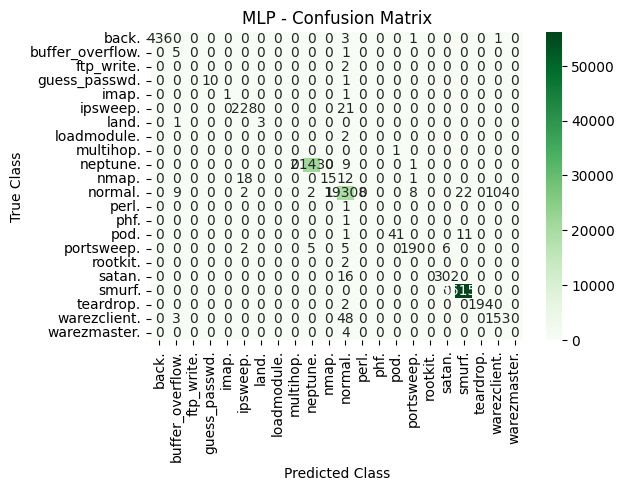

In [59]:
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    random_state=42,
    max_iter=200
)

mlp_classifier.fit(X_train, y_train)

y_pred_mlp = mlp_classifier.predict(X_test)

mlp_recall = recall_score(y_test, y_pred_mlp, average='weighted')
print(f"[MLP] Recall Score: {mlp_recall:.4f}")

unique_labels = np.unique(y_test)
print("\n[MLP] Classification Report:")
print(classification_report(
    y_test,
    y_pred_mlp,
    target_names=[le.classes_[i] for i in unique_labels],
    labels=unique_labels
))

cm_mlp = confusion_matrix(y_test, y_pred_mlp, labels=unique_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Greens',
            xticklabels=[le.classes_[i] for i in unique_labels],
            yticklabels=[le.classes_[i] for i in unique_labels])
plt.title("MLP - Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

## KNN Classifier
- **Model:** Trained a k-Nearest Neighbors (KNN) Classifier with 5 neighbors.
- **Performance:**
  - Achieved a **weighted recall score of 0.9985**, demonstrating strong overall detection.
  - Major classes like "normal" and "smurf" had perfect precision, recall, and F1-scores of **1.00**.
  - Minority classes like "ftp_write" and "loadmodule" struggled, with F1-scores of **0.00** due to very limited samples.
- **Macro Average Recall:** Scored **0.67**, highlighting challenges with underrepresented classes.
- **Strengths:** Weighted average F1-score of **1.00**, driven by excellent performance for dominant classes.
- **Improvements:** Could benefit from balancing techniques or tuning `n_neighbors` to improve detection for rare classes.


[KNN] Recall Score: 0.9985

[KNN] Classification Report:
                  precision    recall  f1-score   support

           back.       1.00      0.99      0.99       441
buffer_overflow.       1.00      0.83      0.91         6
      ftp_write.       0.00      0.00      0.00         2
   guess_passwd.       1.00      0.91      0.95        11
           imap.       1.00      0.50      0.67         2
        ipsweep.       0.89      0.95      0.92       249
           land.       1.00      0.75      0.86         4
     loadmodule.       0.00      0.00      0.00         2
       multihop.       0.00      0.00      0.00         1
        neptune.       1.00      1.00      1.00     21440
           nmap.       0.73      0.41      0.53        46
         normal.       1.00      1.00      1.00     19456
           perl.       0.00      0.00      0.00         1
            phf.       1.00      1.00      1.00         1
            pod.       0.98      1.00      0.99        53
      portswee

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


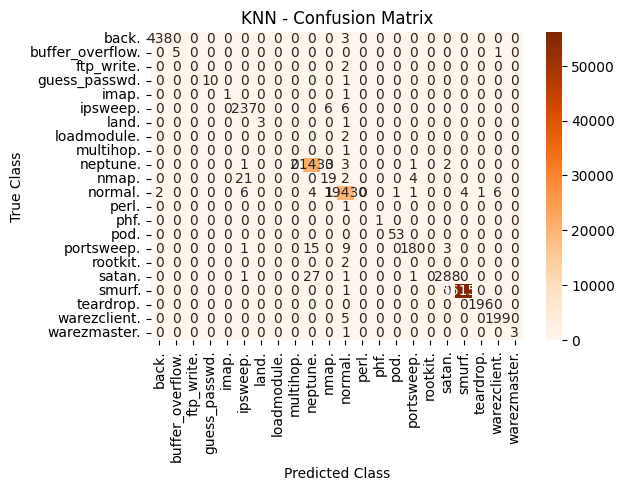

In [62]:
knn_classifier = KNeighborsClassifier(
    n_neighbors=5,
    weights='uniform'
)

knn_classifier.fit(X_train, y_train)

y_pred_knn = knn_classifier.predict(X_test)

knn_recall = recall_score(y_test, y_pred_knn, average='weighted')
print(f"[KNN] Recall Score: {knn_recall:.4f}")

unique_labels = np.unique(y_test)
print("\n[KNN] Classification Report:")
print(classification_report(
    y_test,
    y_pred_knn,
    target_names=[le.classes_[i] for i in unique_labels],
    labels=unique_labels
))

cm_knn = confusion_matrix(y_test, y_pred_knn, labels=unique_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Oranges',
            xticklabels=[le.classes_[i] for i in unique_labels],
            yticklabels=[le.classes_[i] for i in unique_labels])
plt.title("KNN - Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

## Cross-Validation Results

- **Setup:**
  - I used **Stratified K-Fold Cross-Validation** with 5 splits to ensure balanced class distribution in each fold.

- **Classifiers Tested:**
  - Decision Tree
  - MLP Classifier
  - KNN

- **Results:**
  - **Decision Tree:** Achieved a 5-fold weighted recall of **0.9997 ± 0.0001**, showing consistent and high performance.
  - **MLP Classifier:** Achieved a 5-fold weighted recall of **0.9962 ± 0.0016**, slightly lower than the Decision Tree but still strong.
  - **KNN Classifier:** Achieved a 5-fold weighted recall of **0.9986 ± 0.0001**, also showing strong performance and consistency.


In [66]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

recall_scorer = make_scorer(recall_score, average='weighted')

classifiers = {
    "Decision Tree": dt_classifier,
    "MLP": mlp_classifier,
    "KNN": knn_classifier
}

for name, clf in classifiers.items():
    cv_scores = cross_val_score(
        clf,
        X,
        y_encoded,
        cv=skf,
        scoring=recall_scorer
    )

    print(f"{name} - 5-Fold CV Recall (weighted): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Decision Tree - 5-Fold CV Recall (weighted): 0.9997 ± 0.0001


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


MLP - 5-Fold CV Recall (weighted): 0.9962 ± 0.0016


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


KNN - 5-Fold CV Recall (weighted): 0.9986 ± 0.0001


# Hyper-parameters tuning

## Setting up experiment tracking method

In [68]:
def run_experiment(algorithm_name, model, X_train, y_train, X_test, y_test, param_desc, results_list):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    recall_val = recall_score(y_test, y_pred, average='weighted')

    results_list.append([
        algorithm_name,
        param_desc,
        f"{recall_val:.4f}"
    ])

## Splitting into training and test sets

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)


# Experiments

### Decision Tree Experiments
- I created two Decision Tree classifiers with different configurations:
  - `dt1` uses 2 samples splits and a max depth of 5.
  - `dt2` uses 5 samples splits and a max depth of 10.
- I ran both models using `run_experiment`, which trained them, calculated their weighted recall scores, and saved the results.  
- This helped me to compare how different hyperparameters affect the Decision Tree performance.



In [74]:
results = []

dt1 = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=2,
    class_weight='balanced',
    random_state=42
)
run_experiment("Decision Tree", dt1, X_train, y_train, X_test, y_test,
               "max_depth=5, min_samples_split=2", results)

dt2 = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)
run_experiment("Decision Tree", dt2, X_train, y_train, X_test, y_test,
               "max_depth=10, min_samples_split=5", results)


## Random Forest Experiments

- I created two Random Forest classifiers with different configurations:
  - `rf1` uses 50 estimators and a max depth of 10.
  - `rf2` uses 200 estimators and no depth limit (`max_depth=None`).
- I ran both models using `run_experiment`, which trained them, calculated their weighted recall scores, and saved the results.  
- This helped me to compare how different hyperparameters affect the Random Forest's performance.



In [75]:
rf1 = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
run_experiment("Random Forest", rf1, X_train, y_train, X_test, y_test,
               "n_estimators=50, max_depth=10", results)

rf2 = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)
run_experiment("Random Forest", rf2, X_train, y_train, X_test, y_test,
               "n_estimators=200, max_depth=None", results)

## KNN Experiments
- I created two K-Nearest Neighbors (KNN) classifiers with different configurations:
  - `knn1` uses 3 neighbors and uniform weights.
  - `knn2` uses 10 neighbors and distance-based weights.
- I ran both models using `run_experiment`, which trained them, calculated their weighted recall scores, and stored the results.  
- This helped me compare how the number of neighbors and weighting strategies affects the KNN's performance.

In [76]:
knn1 = KNeighborsClassifier(
    n_neighbors=3,
    weights='uniform'
)
run_experiment("KNN", knn1, X_train, y_train, X_test, y_test,
               "n_neighbors=3, weights=uniform", results)

knn2 = KNeighborsClassifier(
    n_neighbors=10,
    weights='distance'
)
run_experiment("KNN", knn2, X_train, y_train, X_test, y_test,
               "n_neighbors=10, weights=distance", results)


## MLP Experiments
- I created multiple MLP Classifiers with different configurations to explore the impact of various hyperparameters.
- Each experiment varied parameters such as `hidden_layer_sizes`, `activation`, `solver`, and `alpha` to assess their effects on model performance.
- I ran all experiments using `run_experiment`, which trained the models, calculated their weighted recall scores, and stored the results.

### Configurations Tested:
1. **`hidden_layer_sizes=(50,50), activation=relu`:**
   - Used two hidden layers, each with 50 neurons, and the ReLU activation function.
   - This configuration tests a smaller network with ReLU activation.

2. **`hidden_layer_sizes=(100,100), activation=relu`:**
   - Used two hidden layers, each with 100 neurons, and ReLU activation.
   - Explores the performance of a larger network with the same activation.

3. **`hidden_layer_sizes=(100,), activation=tanh`:**
   - Used a single hidden layer with 100 neurons and the Tanh activation function.
   - Tests how Tanh compares to ReLU in a simpler architecture.

4. **`hidden_layer_sizes=(100,), solver=lbfgs`:**
   - Used a single hidden layer with 100 neurons and the `lbfgs` solver.
   - Tests a solver optimized for smaller datasets compared to the default Adam solver.

5. **`hidden_layer_sizes=(100,), alpha=0.01`:**
   - Used a single hidden layer with 100 neurons and a regularization parameter (`alpha`) of 0.01.
   - Tests the impact of stronger regularization on model performance.

6. **`hidden_layer_sizes=(100,), alpha=0.0001`:**
   - Used a single hidden layer with 100 neurons and a regularization parameter (`alpha`) of 0.0001.
   - Explores the effect of weaker regularization.

7. **`hidden_layer_sizes=(200,), activation=relu`:**
   - Used a single hidden layer with 200 neurons and ReLU activation.
   - Tests a larger network to see how increasing neurons affects performance.

8. **`hidden_layer_sizes=(100,), activation=logistic`:**
   - Used a single hidden layer with 100 neurons and the Logistic (Sigmoid) activation function.
   - Compares Logistic activation with ReLU and Tanh.

9. **`hidden_layer_sizes=(150,100), solver=adam`:**
   - Used two hidden layers with 150 and 100 neurons, respectively, and the Adam solver.
   - Tests a deeper network with default settings to see its effect on recall.

- These experiments allowed me to systematically evaluate how different network structures and hyperparameters influence MLP Classifier performance.


In [77]:
def mlp_experiment(params_desc, **mlp_params):
    mlp = MLPClassifier(
        random_state=42,
        max_iter=300,
        **mlp_params
    )
    run_experiment("MLP", mlp, X_train, y_train, X_test, y_test, params_desc, results)

mlp_experiment("hidden_layer_sizes=(50,50), activation=relu",
               hidden_layer_sizes=(50,50),
               activation='relu')

mlp_experiment("hidden_layer_sizes=(100,100), activation=relu",
               hidden_layer_sizes=(100,100),
               activation='relu')

mlp_experiment("hidden_layer_sizes=(100,), activation=tanh",
               hidden_layer_sizes=(100,),
               activation='tanh')

mlp_experiment("hidden_layer_sizes=(100,), solver=lbfgs",
               hidden_layer_sizes=(100,),
               solver='lbfgs')

mlp_experiment("hidden_layer_sizes=(100,), alpha=0.01",
               hidden_layer_sizes=(100,),
               alpha=0.01)

mlp_experiment("hidden_layer_sizes=(100,), alpha=0.0001",
               hidden_layer_sizes=(100,),
               alpha=0.0001)

mlp_experiment("hidden_layer_sizes=(200,), activation=relu",
               hidden_layer_sizes=(200,),
               activation='relu')

mlp_experiment("hidden_layer_sizes=(100,), activation=logistic",
               hidden_layer_sizes=(100,),
               activation='logistic')

mlp_experiment("hidden_layer_sizes=(150,100), solver=adam",
               hidden_layer_sizes=(150,100),
               solver='adam')


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Results

- **Decision Tree:**
  - The first Decision Tree (max_depth=5) achieved a recall score of **0.7935**, while increasing the depth to 10 improved the score to **0.8082**.
  - This shows that increasing tree depth helps, but further improvements may require more advanced models.

- **Random Forest:**
  - The Random Forest with 50 estimators and max_depth=10 achieved a high recall score of **0.9920**.
  - Increasing the number of estimators to 200 and removing the depth limit slightly improved the score to **0.9998**, indicating strong overall performance.

- **KNN:**
  - The KNN classifier with 3 neighbors and uniform weights scored **0.9986**, while increasing neighbors to 10 with distance-based weights had almost no impoact on the score.

- **MLP Classifier:**
  - The MLP models performed well overall, with the best recall score of **0.9978**.
  - The `lbfgs` solver produced poor results (**0.0000**), due to convergence issues with the dataset.

### Key Observations:
1. Random Forest and MLP achieved the highest recall scores, indicating their effectiveness for this task.
2. KNN also performed well, slightly below Random Forest and MLP, but still reliable for intrusion detection.
3. Decision Tree had the lowest recall scores, highlighting its limitations compared to ensemble and neural network models.


In [79]:
results_df = pd.DataFrame(results, columns=["Algorithm", "Parameters", "Metrics Score"])
results_df

,Algorithm,Parameters,Metrics Score
0,Decision Tree,"max_depth=5, min_samples_split=2",0.7935
1,Decision Tree,"max_depth=10, min_samples_split=5",0.8082
2,Random Forest,"n_estimators=50, max_depth=10",0.9920
3,Random Forest,"n_estimators=200, max_depth=None",0.9998
4,KNN,"n_neighbors=3, weights=uniform",0.9986
5,KNN,"n_neighbors=10, weights=distance",0.9985
6,MLP,"hidden_layer_sizes=(50,50), activation=relu",0.9953
7,MLP,"hidden_layer_sizes=(100,100), activation=relu",0.9965
8,MLP,"hidden_layer_sizes=(100,), activation=tanh",0.9978
9,MLP,"hidden_layer_sizes=(100,), solver=lbfgs",0.0000


## Summary

This project tested different algorithms to detect network intrusions using the KDD-99 dataset. Here are the main insights:

1. **Decision Tree:**
   - Gave moderate recall scores, improving with deeper trees.
   - It was weaker than advanced models, needing better methods for rare classes.

2. **Random Forest:**
   - Had the best recall score (**0.9998**) and worked very well overall.
   - More estimators and no depth limits made it even more robust.

3. **KNN Classifier:**
   - Performed consistant with recall scores around **0.9986**.
   - Changes to neighbors or weights didn’t change results much.

4. **MLP Classifier:**
   - Scored **0.9978**, doing well with tuning, but struggled with the `lbfgs` solver.

### Conclusion:
Random Forest was the most reliable model, while MLP and KNN also performed strong. Decision Trees showed limits as a simple model. Balancing rare classes and testing more advanced neural nets could improve results further.
